In [96]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from glob import glob

In [97]:
BASE_PATH = "C:\\Users\\sktsa\\Projects\\visual-perception\\data\\mech\\"
TRAIN_PATH = BASE_PATH + 'train'
TEST_PATH = BASE_PATH + 'val'

In [98]:
image_files = glob(TRAIN_PATH + '/*/*.png')
image_test_files = glob(TEST_PATH + '/*/*.png')

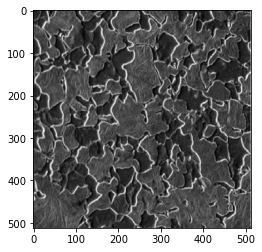

In [99]:
import matplotlib.pyplot as plt

plt.imshow(image.load_img(np.random.choice(image_files)))

### Inceptionv3

In [100]:
# # create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False)

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(512, kernel_initializer='he_uniform', activation='relu')(x)
# x = Dense(512, kernel_initializer='he_uniform', activation='relu')(x)
# x = Dense(256, kernel_initializer='he_uniform', activation='relu')(x)
# predictions = Dense(3, kernel_initializer='he_uniform')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# for layer in base_model.layers:
#     layer.trainable = False

In [115]:
IMAGE_SIZE = [100, 100]
epochs = 50
BATCH_SIZE = 32

In [116]:
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, AveragePooling2D, Activation, Flatten
from tensorflow.keras import layers, models
input = Input(shape=IMAGE_SIZE + [1], name="input")
x = Conv2D(6, 5, activation="tanh")(input)
x = AveragePooling2D(2)(x)
x = Activation('sigmoid')(x)
x = Conv2D(16, 5, activation='tanh')(x)
x = AveragePooling2D(2)(x)
x = Activation('sigmoid')(x)
x = Conv2D(120, 5, activation='tanh')(x)
x = Flatten()(x)
x = Dense(84, activation='tanh')(x)
prediction = Dense(3)(x)

model = Model(input, prediction, name="leNet")

In [117]:
model.summary()

Model: "leNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 96, 96, 6)         156       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 48, 48, 6)         0         
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 6)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 44, 44, 16)        2416      
_________________________________________________________________
average_pooling2d_13 (Averag (None, 22, 22, 16)        0         
_________________________________________________________________
activation_13 (Activation)   (None, 22, 22, 16)        0     

In [118]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
model.compile(loss='mae', optimizer=adam, metrics=['accuracy'])

In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
train_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True)

# No augmentation for validation dataset
val_gen = ImageDataGenerator()

In [120]:
import pandas as pd
df = pd.read_csv(BASE_PATH + 'opt_feat1.csv', names=['U', 'Y', 'F'], skiprows=1)

# perform normalization on columns
x = df.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=['U', 'Y', 'F'])

# Add images
df['image'] = ['{}//{}.png'.format(i, i) for i in range(1, len(df) + 1)]

# take 70% as training data
df_train = df.sample(frac = 0.7)
df_test = df.drop(df_train.index)

In [121]:
train_images = train_gen.flow_from_dataframe(df_train,
                                       TRAIN_PATH,
                                       x_col='image',
                                       y_col=['U', 'Y', 'F'],
                                       class_mode='raw',
                                       color_mode='grayscale',
                                       batch_size=BATCH_SIZE,
                                       target_size=IMAGE_SIZE)

Found 24 validated image filenames.


(24, 100, 100, 1) 24 [0.00555556 0.21019108 0.24358974]
min:  50.810608 max:  254.9087


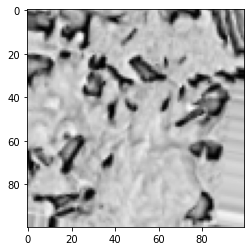

In [122]:
for x, y in train_images:
    print(x.shape, len(y), y[0])
    print('min: ', x[0].min(), 'max: ', x[0].max())
    plt.imshow(x[0], cmap='binary')
    plt.show()
    break

In [123]:
df_test

,U,Y,F,image
0,0.444444,0.076433,0.102564,1//1.png
1,0.462963,0.140127,0.230769,2//2.png
5,0.259259,0.182590,0.217949,6//6.png
7,0.259259,0.182590,0.217949,8//8.png
17,0.009259,0.214437,0.269231,18//18.png
19,0.222222,0.012739,0.051282,20//20.png
22,0.288889,0.371550,0.064103,23//23.png
25,0.166667,0.033970,0.205128,26//26.png
26,0.833333,0.840764,0.000000,27//27.png
27,0.518519,0.819533,0.320513,28//28.png


In [124]:
train_generator = train_gen.flow_from_dataframe(df_train,
                                                TRAIN_PATH,
                                                x_col='image',
                                                y_col=['U', 'Y', 'F'],
                                                class_mode='raw',
                                                color_mode='grayscale',
                                                batch_size=BATCH_SIZE,
                                                subset='training',
                                                shuffle=True,
                                                target_size=IMAGE_SIZE)

val_generator = val_gen.flow_from_dataframe(df_test,
                                            TEST_PATH,
                                            x_col='image',
                                            batch_size=BATCH_SIZE,
                                            y_col=['U', 'Y', 'F'],
                                            class_mode='raw',
                                            color_mode='grayscale',
                                            # subset='validation',
                                            shuffle=True,
                                            target_size=IMAGE_SIZE)

Found 24 validated image filenames.
Found 10 validated image filenames.


In [125]:
if train_generator.n < 32 or val_generator.n < 32:
    STEP_SIZE_TRAIN = 1
    STEP_SIZE_VALID = 1
else:
    STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID = val_generator.n // val_generator.batch_size
print(STEP_SIZE_TRAIN)
r = model.fit(train_generator,
              validation_data=val_generator,
              epochs=epochs,
              steps_per_epoch=STEP_SIZE_TRAIN,
              validation_steps=STEP_SIZE_VALID)

1
Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.3177 - accuracy: 0.3333 - val_loss: 2.3788 - val_accuracy: 0.3000
Epoch 2/50
1/1 [==============================] - 0s 248ms/step - loss: 2.3101 - accuracy: 0.2917 - val_loss: 2.0447 - val_accuracy: 0.3000
Epoch 3/50
1/1 [==============================] - 0s 245ms/step - loss: 2.0008 - accuracy: 0.2917 - val_loss: 1.9043 - val_accuracy: 0.3000
Epoch 4/50
1/1 [==============================] - 0s 243ms/step - loss: 1.9465 - accuracy: 0.2917 - val_loss: 1.3887 - val_accuracy: 0.3000
Epoch 5/50
1/1 [==============================] - 0s 248ms/step - loss: 1.4254 - accuracy: 0.2917 - val_loss: 0.7131 - val_accuracy: 0.3000
Epoch 6/50
1/1 [==============================] - 0s 256ms/step - loss: 0.7020 - accuracy: 0.2917 - val_loss: 0.5628 - val_accuracy: 0.2000
Epoch 7/50
1/1 [==============================] - 0s 261ms/step - loss: 0.5591 - accuracy: 0.3750 - val_loss: 0.5988 - val_accuracy: 0.2000
Epoch 8/50
1/1 [=====

In [126]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame.from_dict(r.history)

<AxesSubplot:>

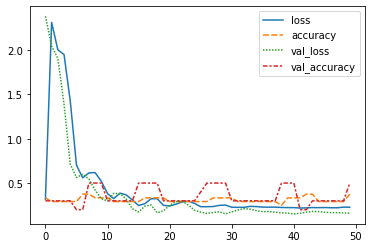

In [127]:
sns.lineplot(data=df)

In [128]:
df

,loss,accuracy,val_loss,val_accuracy
0,0.317701,0.333333,2.378817,0.3
1,2.310079,0.291667,2.044686,0.3
2,2.000793,0.291667,1.904319,0.3
3,1.946523,0.291667,1.388659,0.3
4,1.425389,0.291667,0.713109,0.3
5,0.701997,0.291667,0.562794,0.2
6,0.559144,0.375000,0.598787,0.2
7,0.614583,0.375000,0.546089,0.5
8,0.617799,0.333333,0.421803,0.5
9,0.520130,0.333333,0.323894,0.5
